# House sales predictions

## Introduction

In this lab the objective is to predict the price of a house based on its features. We have some training data containing 79 features excluding the Id and sales price. And some test data containg those same features but not the sales price. To predict the values of these test houses we have to make some models, that use these supplied features and turns them into a prediction of the value. Before we can start the prediction, we first need to explore the data for features correlating to the price, and abnormalities that may interfare with our predictions. Then we need to enginer our own features to increase the accuracy of our model. Finaly we need to choose the model for our prediction.

## Table of content
1. [Cleaning the data](#first-bullet)

2. [Data Exploration](#second-bullet)
    
    2.1 [Finding feature relations](#third-bullet)
    
    2.2 [Lets plot some features](#fourth-bullet)

## Short summary

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import lightgbm as lgb
import xgboost as xgb
import matplotlib.ticker as ticker
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso , BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.svm import SVR



pd.set_option('display.max_columns', None)
base = "./challenge_data/"

/home/marius/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/marius/.local/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/home/marius/.local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  Deprec

## Reading the data

In [2]:
# loading the data
houseDataDF = pd.read_csv(base + "train.csv")
idColl = houseDataDF.Id
houseDataDF = houseDataDF.drop(["Id"],axis=1)
houseDataDF.index = idColl
trainSetLength = len(houseDataDF.values)
print(houseDataDF.shape)
testDF = pd.read_csv(base + "test.csv")
idColl = testDF.Id
testDF = testDF.drop(["Id"],axis=1)
testDF.index = idColl
print(testDF.shape)

labourForceDF = pd.read_csv(base + "labour_force.csv")
labourForceDF.head(20)

(1200, 80)
(260, 79)


,Month,Year,Unemplyment
0,3,2018,4.1
1,2,2018,4.1
2,1,2018,4.1
3,12,2017,4.1
4,11,2017,4.1
5,10,2017,4.1
6,9,2017,4.2
7,8,2017,4.4
8,7,2017,4.3
9,6,2017,4.3


# Data Exploration

Lets first see how many of the values in data than are empty, None or NAN.

Text(0.5,1,'Percent missing data by feature (training data)')

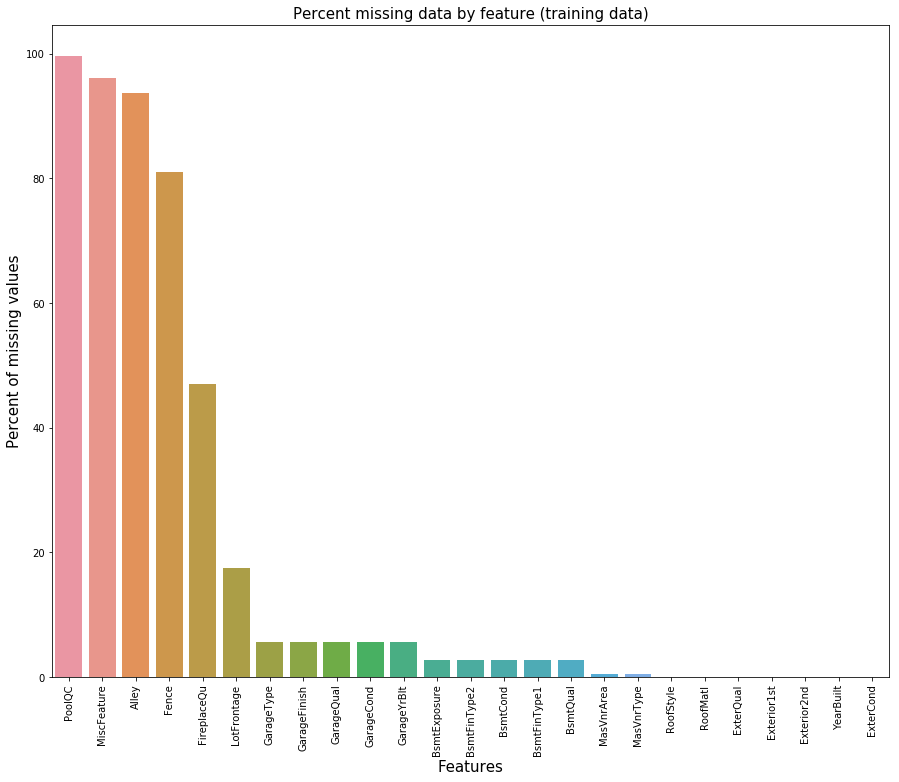

In [3]:
nulls = pd.DataFrame(houseDataDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(houseDataDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (training data)', fontsize=15)

We can see from the plot above that for several features for the training data, over 80% of the values are missing. Lets see if the same applies for the test data.

Text(0.5,1,'Percent missing data by feature (test data)')

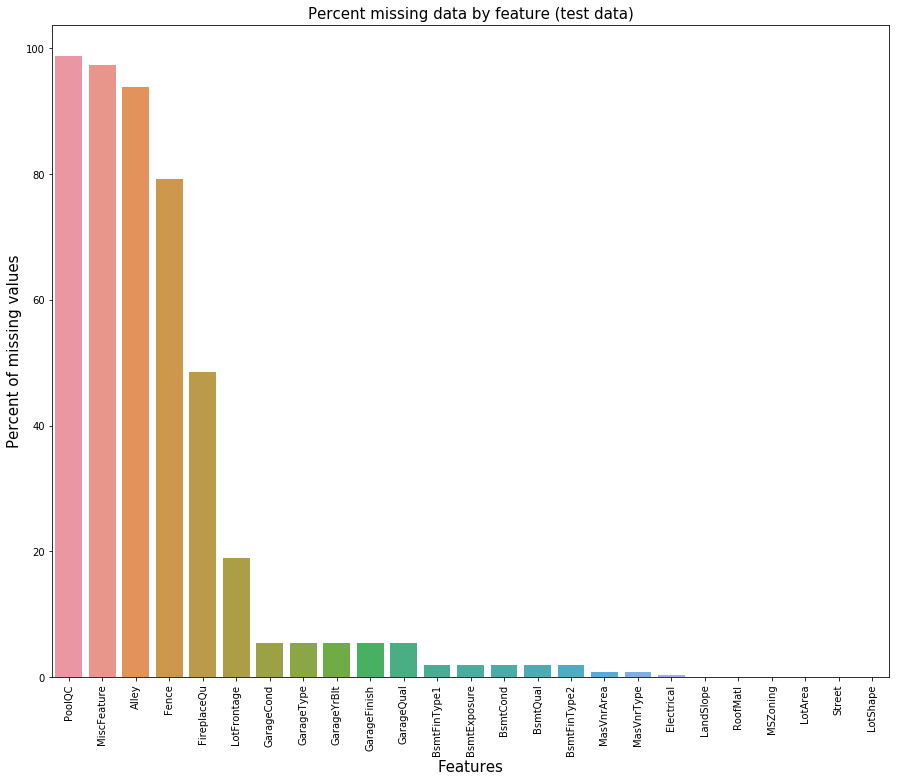

In [4]:
nulls = pd.DataFrame(testDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(testDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (test data)', fontsize=15)

We can see that the percentage of missing values are almost the same for test data as the training data. This is god news, as our predictions are not going to be biased by missing values.

Our data consists of both numerical and caterical features. For making predictions we need to see how these values are distributed. Lets first look at the numerical features from the training data.

In [5]:
categoricals = houseDataDF.select_dtypes(include=[np.number])
categoricals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1133.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,564.553333,1054.700000,1157.430833,344.993333,6.553333,1508.97750,0.421667,0.061667,1.560833,0.382500,2.857500,1.045000,6.494167,0.614167,1978.368932,1.763333,472.604167,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,440.388327,419.996306,375.238607,437.038023,52.077992,517.38033,0.520342,0.247484,0.552165,0.499735,0.819199,0.219123,1.614664,0.642113,24.812865,0.743494,212.722444,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,225.000000,796.000000,882.000000,0.000000,0.000000,1125.75000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,472.000000,1002.500000,1087.000000,0.000000,0.000000,1456.00000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,799.500000,1298.250000,1390.250000,728.000000,0.000000,1764.50000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4676.00000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
categoricals = houseDataDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,75,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1194,1200,1200,1200,1168,1168,1167,1168,1167,1200,1200,1200,1200,1200,1200,636,1133,1133,1133,1133,1200,4,227,47,1200,1200
unique,5,2,2,4,4,2,5,3,25,9,7,5,8,5,6,14,15,4,4,5,6,4,4,4,6,6,4,5,2,5,4,7,5,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,946,1194,41,754,1079,1199,862,1135,179,1035,1186,1001,601,945,1178,417,410,711,747,1050,534,526,1076,784,346,1034,1177,603,1122,1095,602,1117,309,718,500,1081,1093,1107,2,130,44,1036,979


In [7]:
categoricals = testDF.select_dtypes(include=[np.number])
categoricals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,260.000000,211.000000,260.000000,260.000000,260.000000,260.000000,260.000000,258.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,246.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,56.076923,69.876777,10320.288462,6.073077,5.607692,1970.884615,1984.303846,102.403101,437.884615,52.500000,579.642308,1070.026923,1186.607692,356.219231,2.573077,1545.400000,0.442308,0.038462,1.584615,0.384615,2.907692,1.053846,6.626923,0.607692,1979.138211,1.784615,474.715385,90.126923,49.630769,20.919231,2.284615,15.430769,6.680769,57.500000,6.369231,2007.838462
std,40.563048,26.911212,6255.537115,1.383314,1.079798,30.962085,21.213658,169.505783,524.993497,172.108108,449.278872,517.092050,435.144036,434.888547,27.379755,561.432388,0.512902,0.192679,0.545740,0.518159,0.800059,0.226149,1.672872,0.657551,24.154038,0.765921,219.140520,131.361754,68.915161,59.399547,26.005564,60.224091,63.147817,556.196665,2.845137,1.371547
min,20.000000,21.000000,1533.000000,3.000000,3.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,483.000000,0.000000,0.000000,630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1914.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.500000,7500.000000,5.000000,5.000000,1950.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,790.250000,884.000000,0.000000,0.000000,1143.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,6.000000,0.000000,1962.250000,1.000000,332.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,2007.000000
50%,50.000000,67.000000,9600.000000,6.000000,5.000000,1971.500000,1992.000000,0.000000,360.000000,0.000000,514.000000,946.000000,1086.000000,0.000000,0.000000,1510.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,484.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11515.500000,7.000000,6.000000,2001.250000,2004.000000,160.000000,704.750000,0.000000,841.750000,1289.500000,1407.750000,739.500000,0.000000,1844.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,8.000000,1.000000,2003.000000,2.000000,573.000000,168.000000,70.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,63887.000000,10.000000,9.000000,2009.000000,2009.000000,796.000000,5644.000000,1031.000000,2002.000000,6110.000000,4692.000000,1611.000000,384.000000,5642.000000,2.000000,1.000000,3.000000,2.000000,6.000000,2.000000,12.000000,3.000000,2009.000000,4.000000,1418.000000,736.000000,547.000000,301.000000,304.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000


In [8]:
categoricals = testDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,260,260,16,260,260,260,260,260,260,260,260,260,260,260,260,260,260,258,260,260,260,255,255,255,255,255,260,260,260,259,260,260,134,246,246,246,246,260,3,54,7,260,260
unique,5,1,2,4,4,1,5,3,24,8,2,5,8,6,5,11,12,4,4,3,6,4,3,4,6,6,6,4,2,3,4,5,5,5,3,3,4,3,2,4,3,5,5
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,205,260,9,171,232,260,190,247,46,225,259,219,125,196,256,98,94,153,159,232,113,123,235,169,86,222,251,138,243,239,133,243,71,152,105,230,233,233,2,27,5,231,219


## Finding feature relations

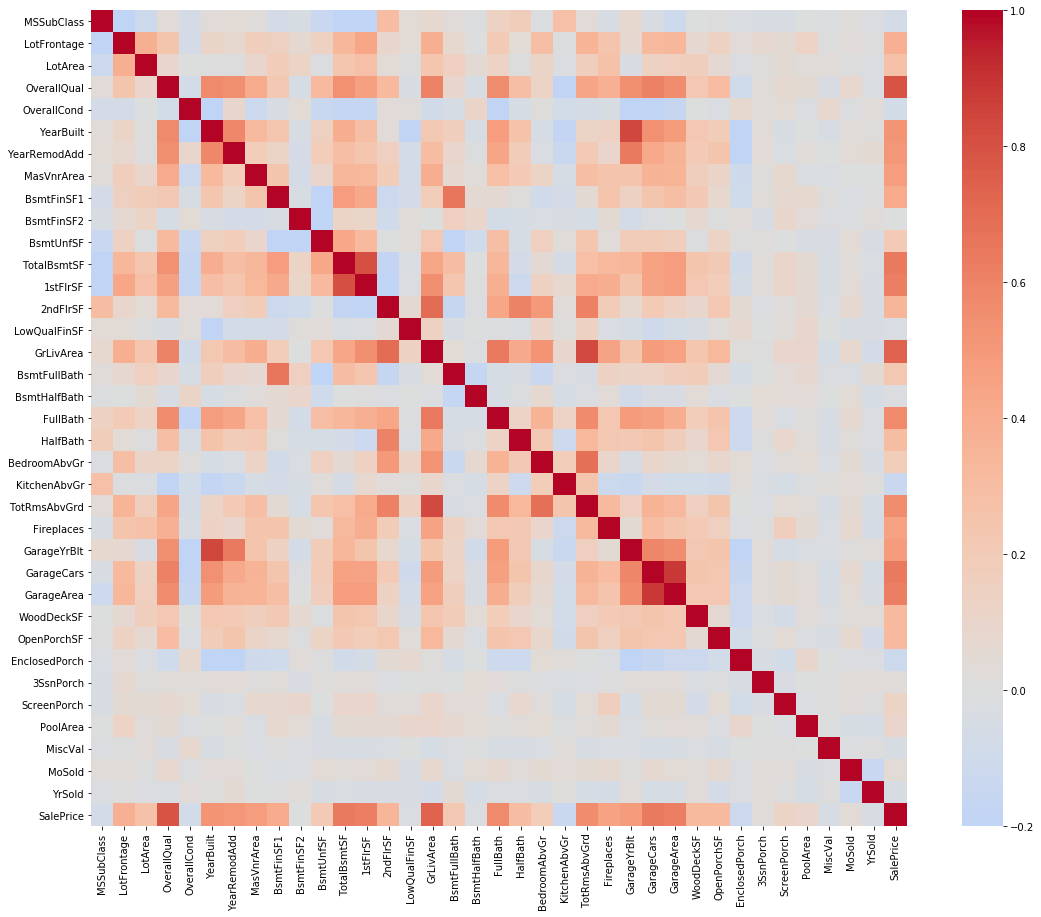

In [9]:
plt.figure(figsize=(20,15))
corr = houseDataDF.corr()


sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-0.2, square=True, center=0,cmap='coolwarm'
           )

In [10]:

corrAsList = list(zip(corr.tail(1).values[0],list(corr)))

sortedCorr = sorted(corrAsList,key=lambda x : x[0],reverse=True)

corrDF = pd.DataFrame(data=np.array(sortedCorr),columns=["Correlation","Feature"])
highestCorrFeatures = corrDF["Feature"].values[1:11]
corrDF

,Correlation,Feature
0,1.0,SalePrice
1,0.7891424854776941,OverallQual
2,0.7403792470454845,GrLivArea
3,0.6419166279661711,TotalBsmtSF
4,0.64096125033065,GarageCars
5,0.6233291704658925,GarageArea
6,0.6185556125238022,1stFlrSF
7,0.5718673954241766,FullBath
8,0.5594350061389467,TotRmsAbvGrd
9,0.5231935965259926,YearBuilt


## Lets plot some features

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

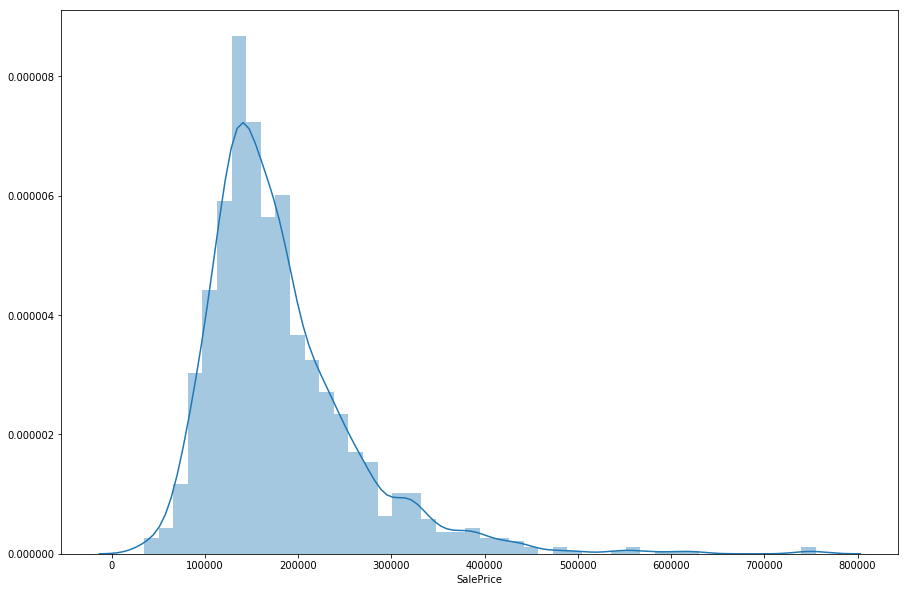

In [11]:
plt.figure(figsize=(15,10))
sns.distplot(houseDataDF.SalePrice)
houseDataDF.SalePrice.describe()

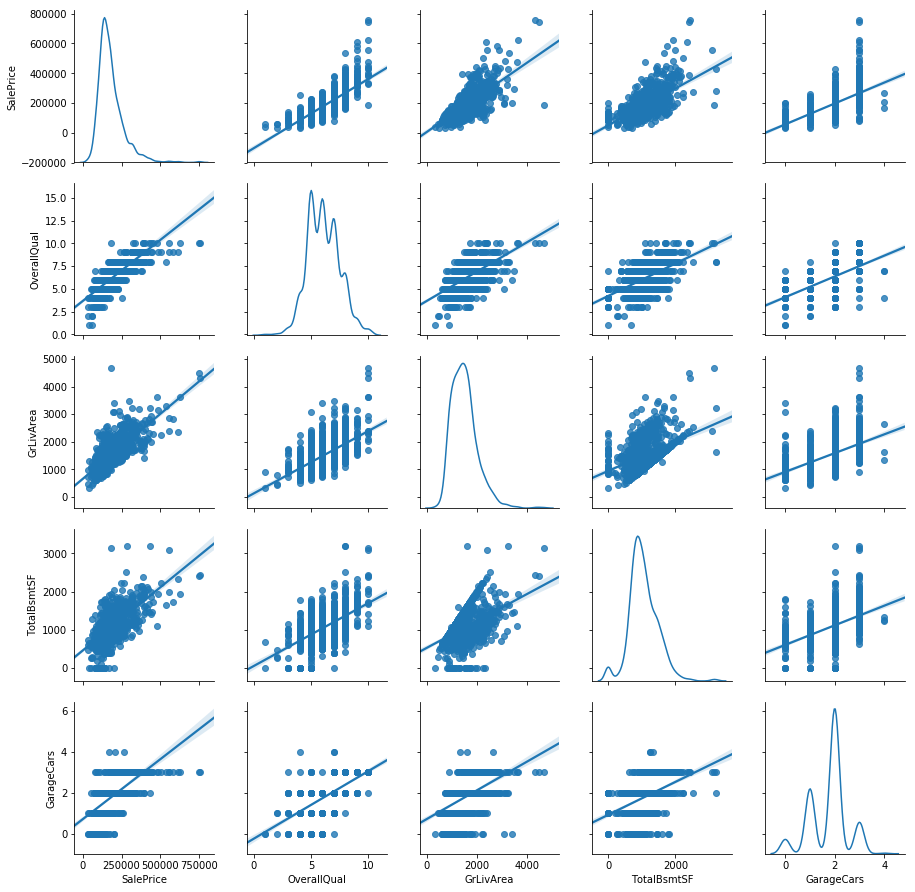

In [12]:
sns.pairplot(houseDataDF[corrDF["Feature"].values[:5]],kind="reg",diag_kind="kde")

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


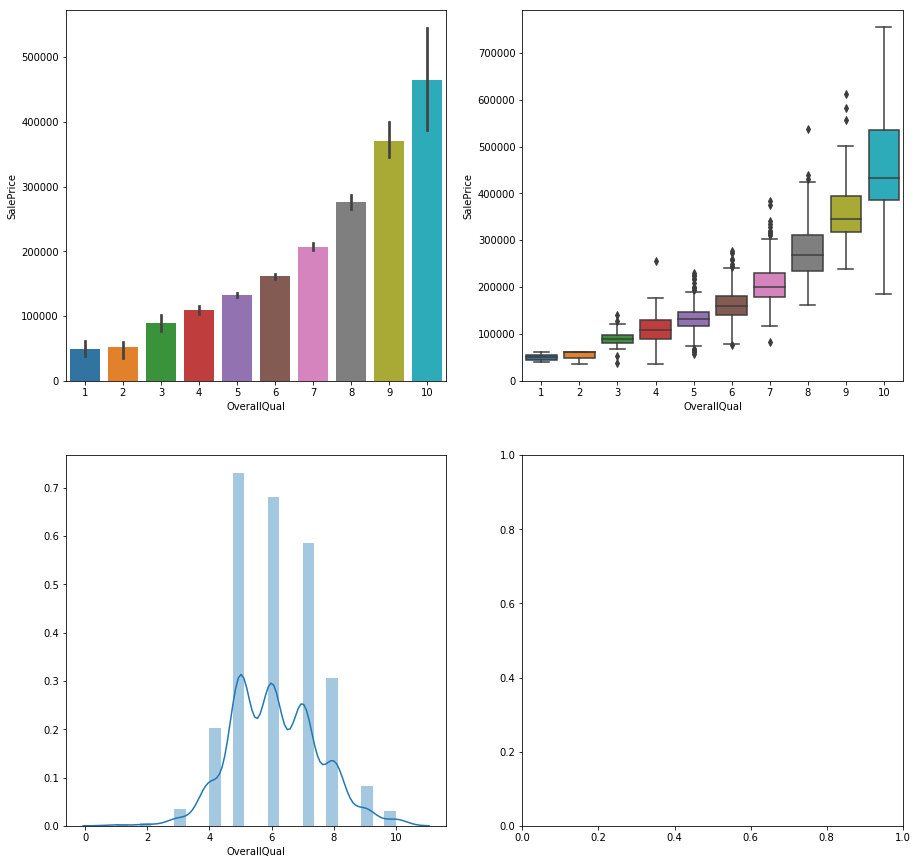

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.barplot(x="OverallQual", y="SalePrice", data=houseDataDF)
plt.subplot(222)
sns.boxplot(x='OverallQual',y='SalePrice', data=houseDataDF)
plt.subplot(223)
sns.distplot(houseDataDF.OverallQual)
plt.subplot(224)

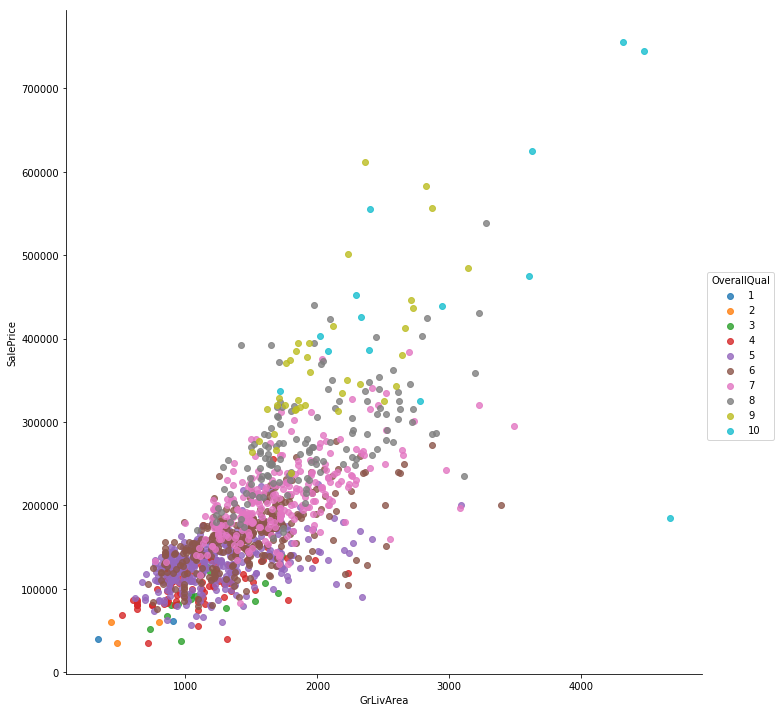

In [14]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 

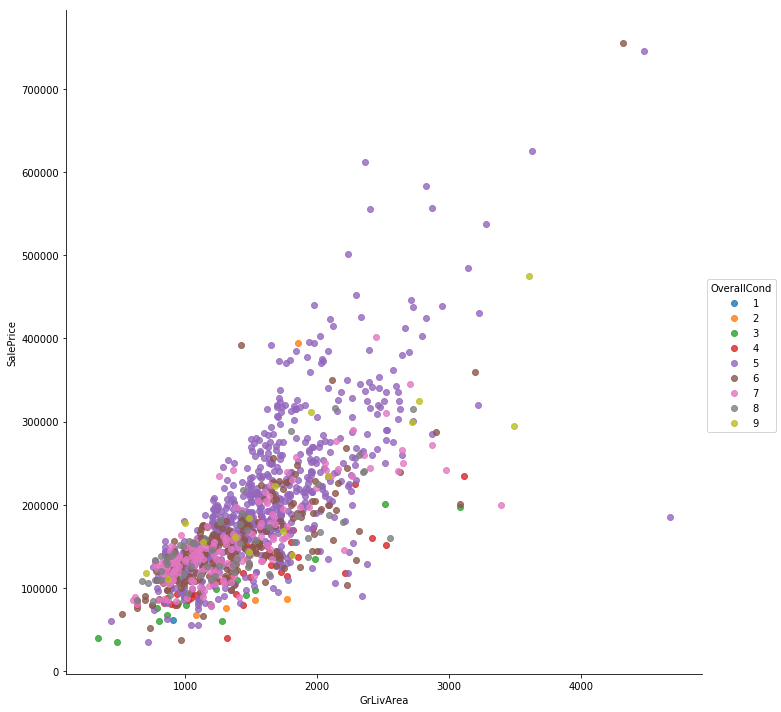

In [15]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallCond") 

In [16]:
res = houseDataDF.query('SalePrice <= 200000 & OverallQual == 10 ')[highestCorrFeatures]
outliers = res.index.values
res

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
524,10,4676,3138,3,884,3138,3,11,2007,2008


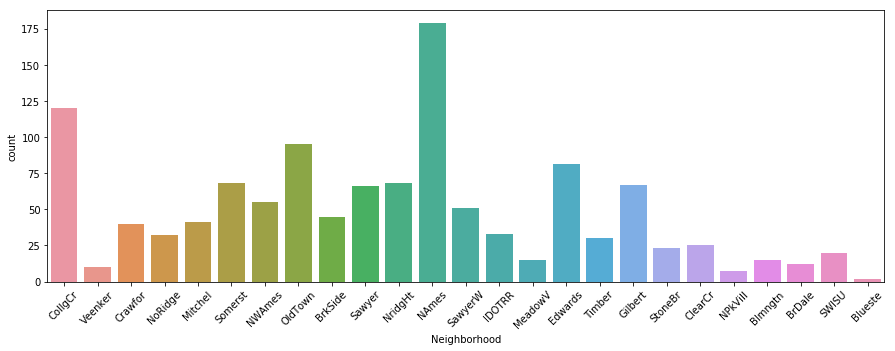

In [17]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='45')
sns.countplot(x="Neighborhood", data=houseDataDF)

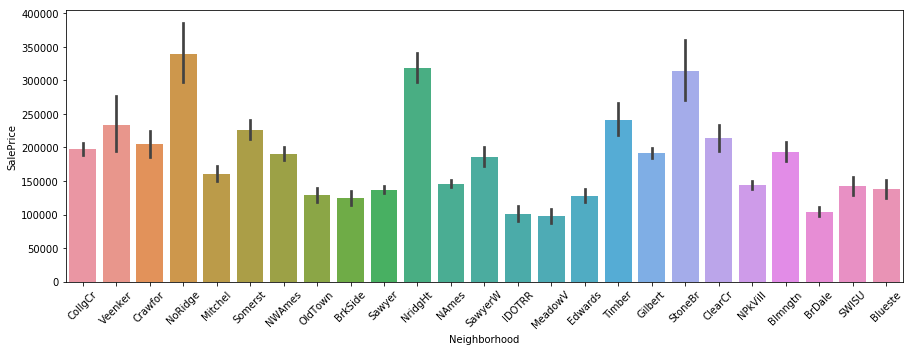

In [18]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='45')
sns.barplot(x="Neighborhood", y="SalePrice", data=houseDataDF)

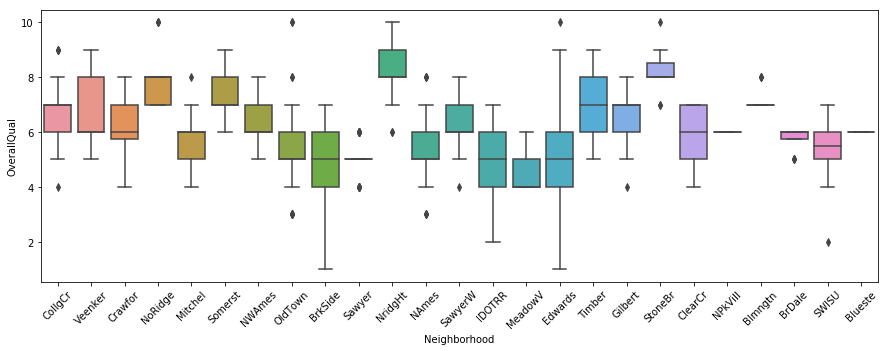

In [19]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='45')
sns.boxplot(x='Neighborhood',
               y='OverallQual', 
               data=houseDataDF)

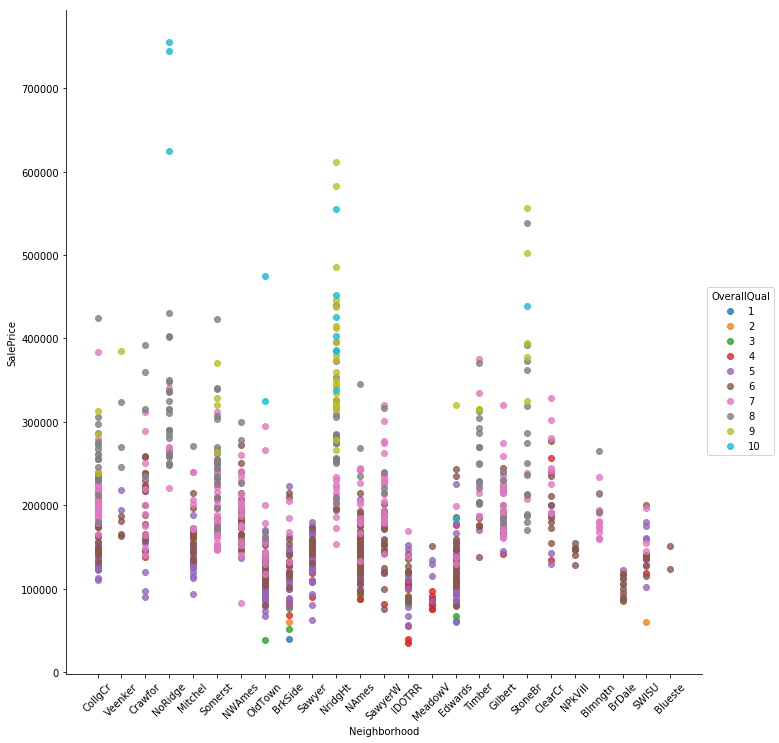

In [20]:
h = sns.lmplot(x="Neighborhood",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 
h.set_xticklabels(rotation=45)

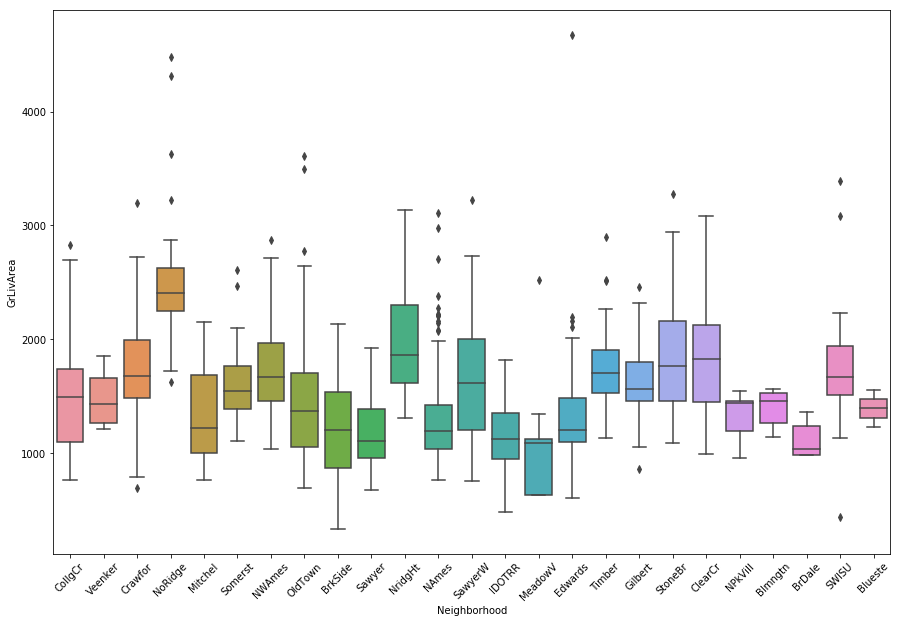

In [21]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='45')
sns.boxplot(x='Neighborhood',
               y='GrLivArea', 
               data=houseDataDF)

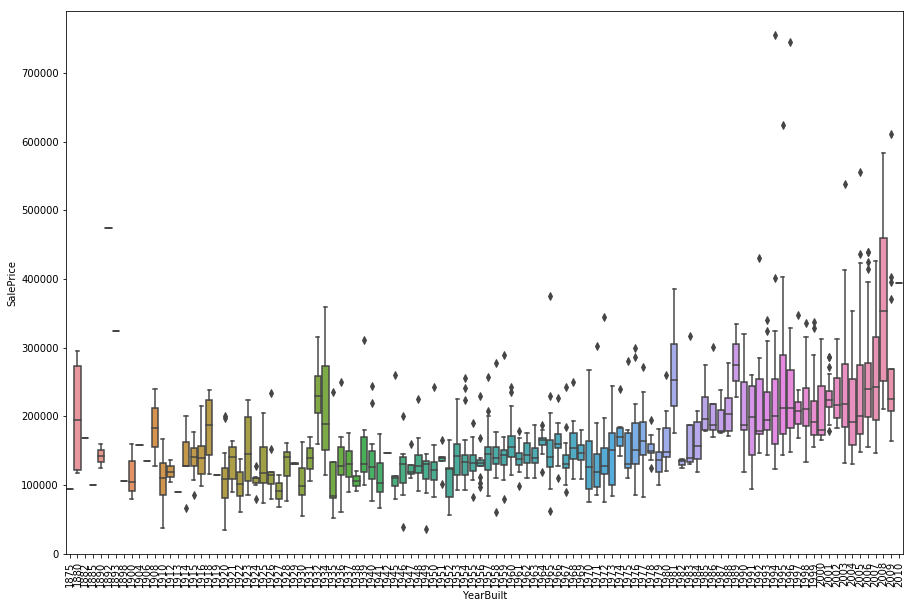

In [22]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
ax = sns.boxplot(x='YearBuilt',
               y='SalePrice', 
               data=houseDataDF)


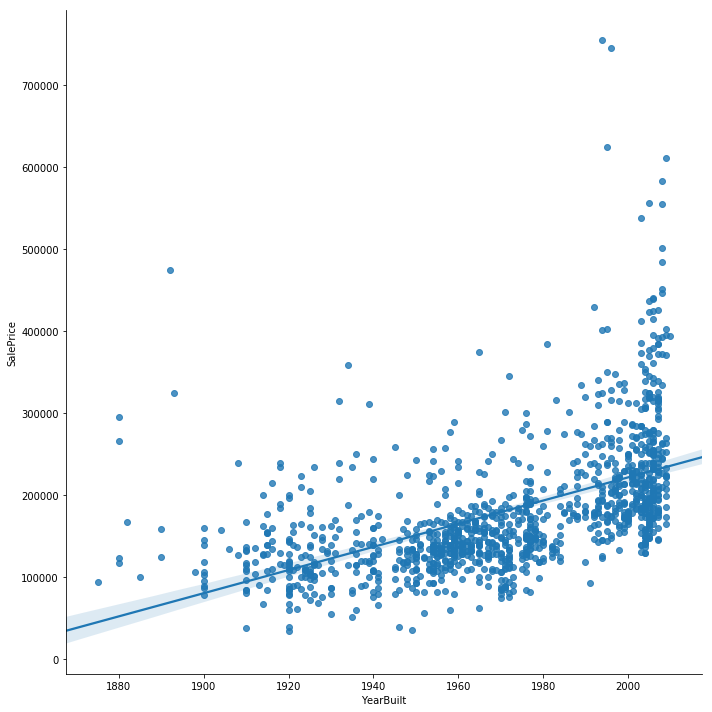

In [23]:
h = sns.lmplot(x="YearBuilt",y="SalePrice",data=houseDataDF,fit_reg=True,size=10) 

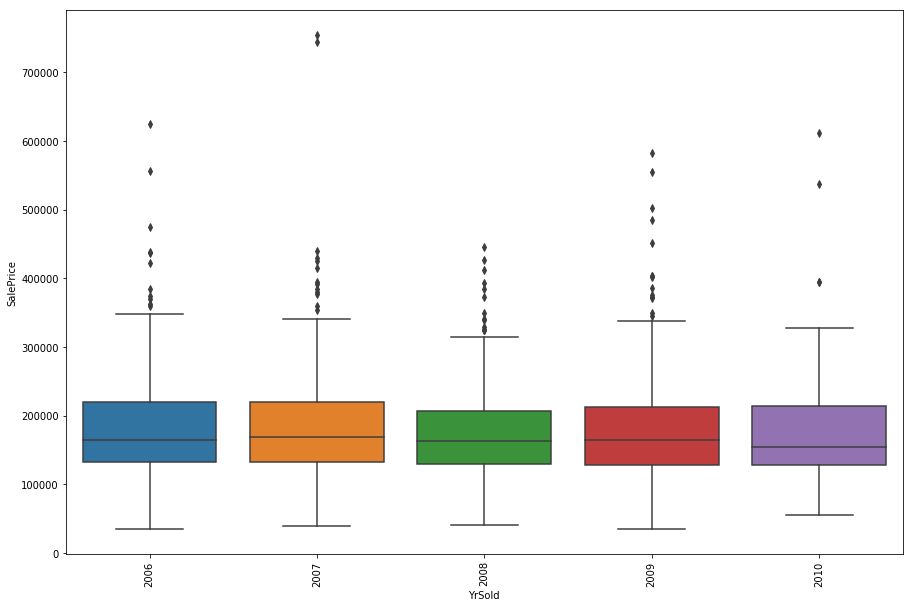

In [24]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='YrSold',
               y='SalePrice', 
               data=houseDataDF)

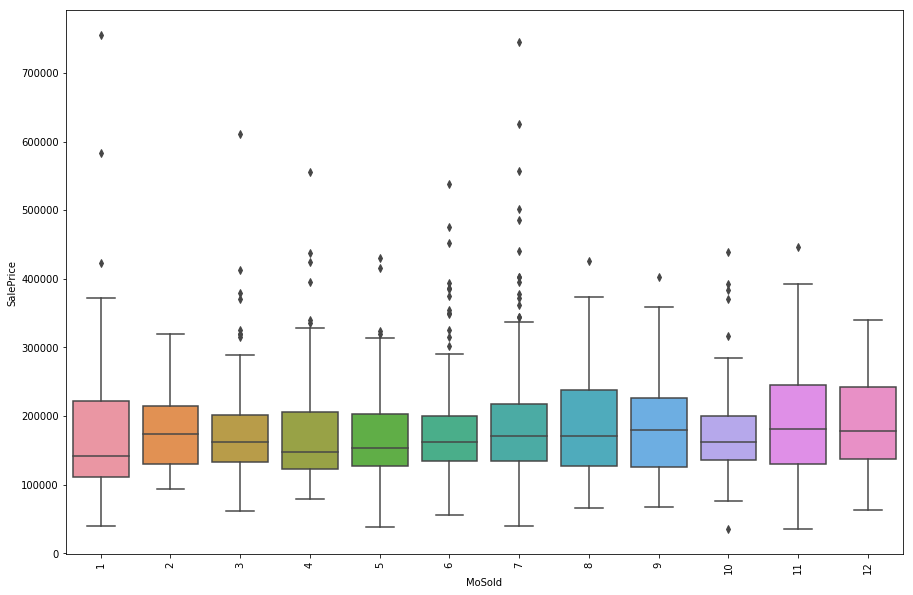

In [25]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.boxplot(x='MoSold',
               y='SalePrice', 
               data=houseDataDF)

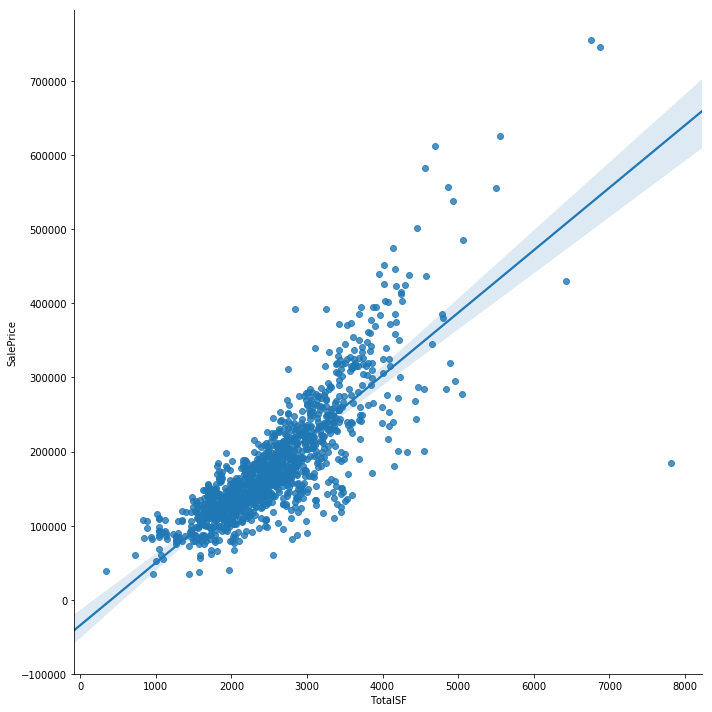

In [26]:
totalSFDF = pd.DataFrame(data=houseDataDF.SalePrice)
totalSFDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
h = sns.lmplot(x="TotalSF",y="SalePrice",data=totalSFDF,fit_reg=True,size=10) 

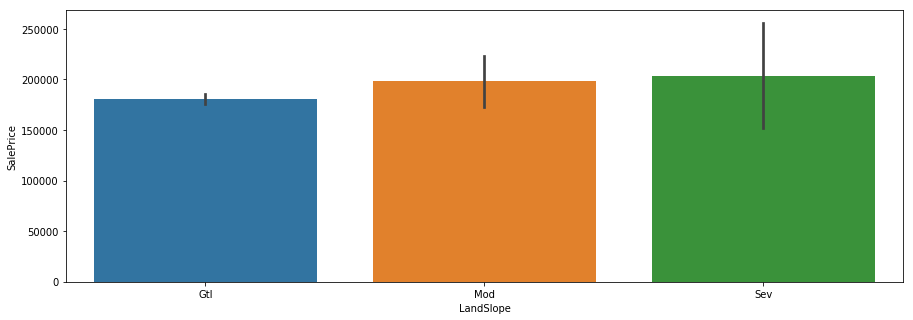

In [27]:
plt.figure(figsize=(15,5))
sns.barplot(x="LandSlope", y="SalePrice", data=houseDataDF)

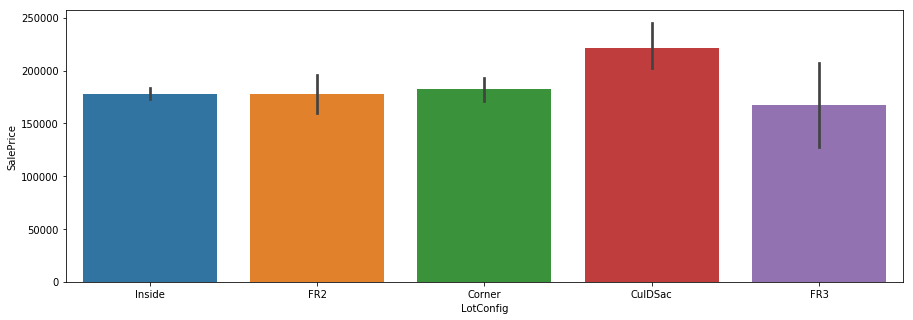

In [28]:
plt.figure(figsize=(15,5))
sns.barplot(x="LotConfig", y="SalePrice", data=houseDataDF)

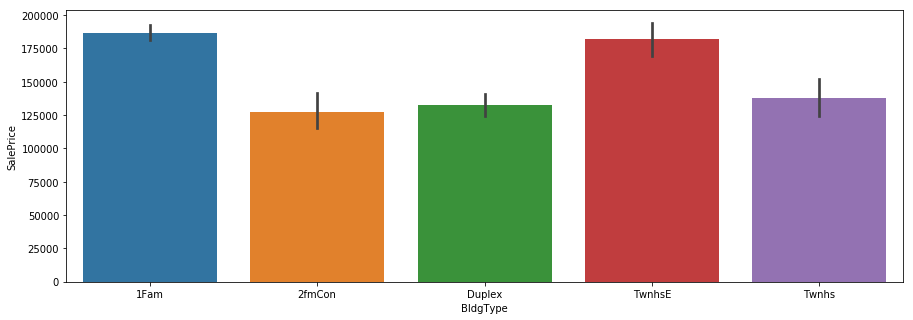

In [29]:
plt.figure(figsize=(15,5))
sns.barplot(x="BldgType", y="SalePrice", data=houseDataDF)

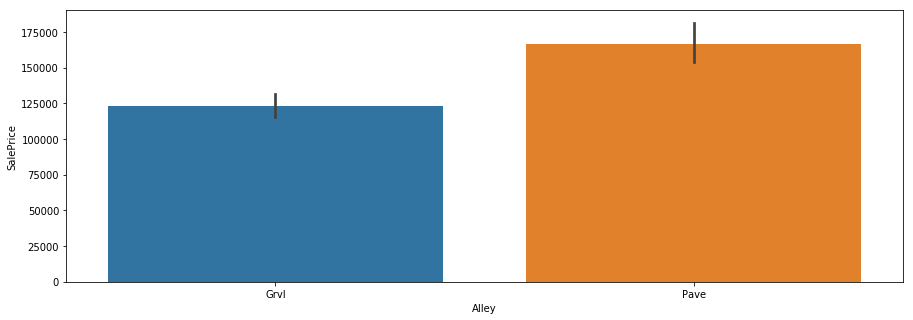

In [30]:
plt.figure(figsize=(15,5))
sns.barplot(x="Alley", y="SalePrice", data=houseDataDF)

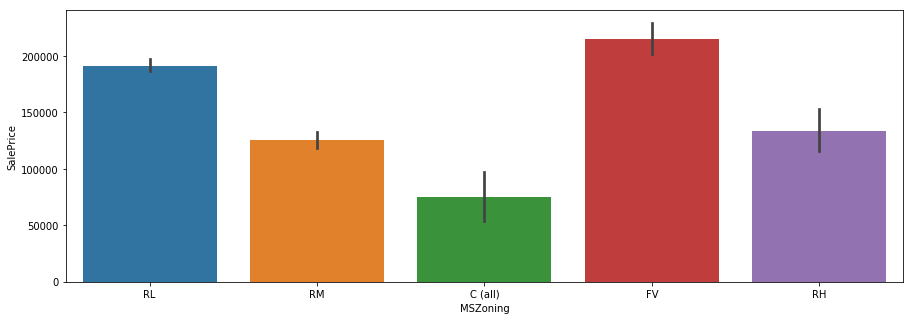

In [31]:
plt.figure(figsize=(15,5))
sns.barplot(x="MSZoning", y="SalePrice", data=houseDataDF)

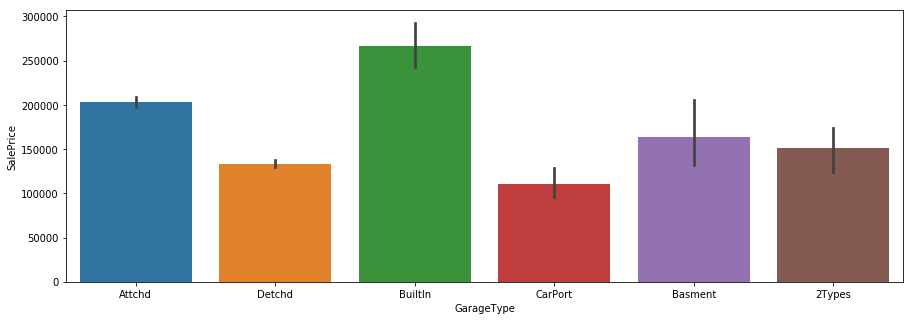

In [32]:
plt.figure(figsize=(15,5))
sns.barplot(x="GarageType", y="SalePrice", data=houseDataDF)

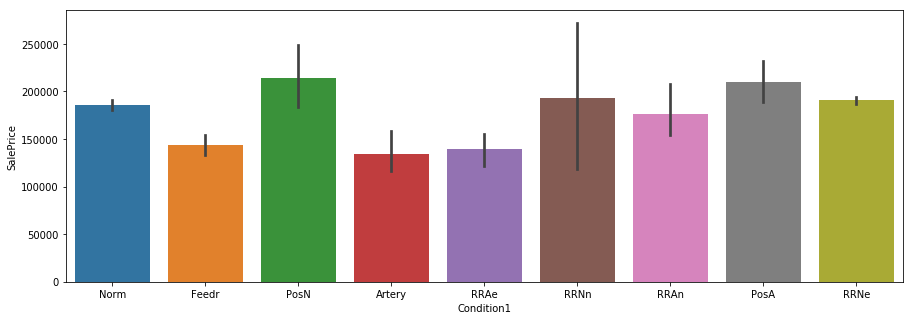

In [33]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition1", y="SalePrice", data=houseDataDF)

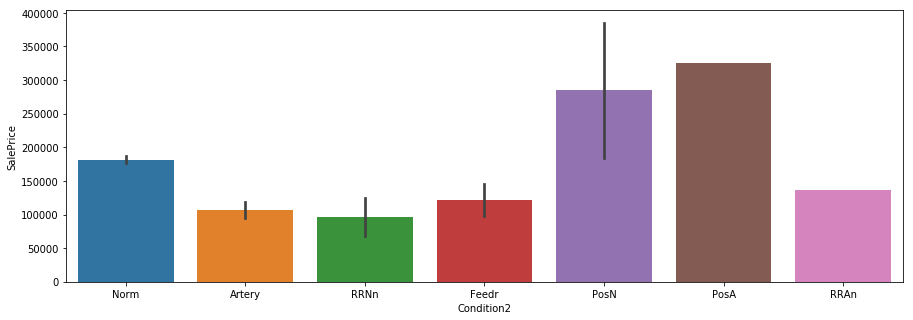

In [34]:
plt.figure(figsize=(15,5))
sns.barplot(x="Condition2", y="SalePrice", data=houseDataDF)

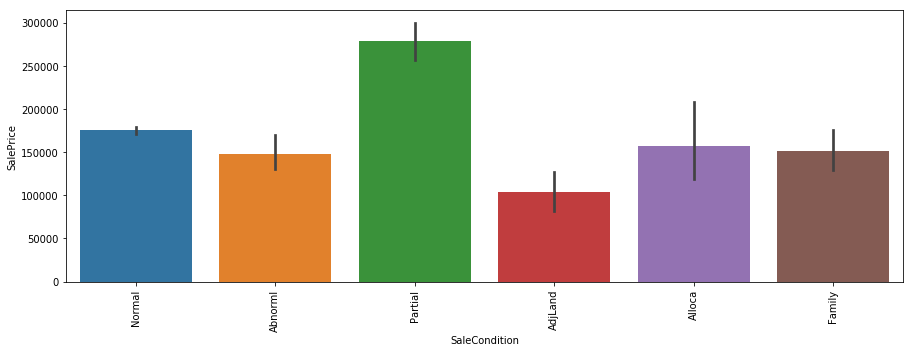

In [35]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='90')
sns.barplot(x="SaleCondition", y="SalePrice", data=houseDataDF)

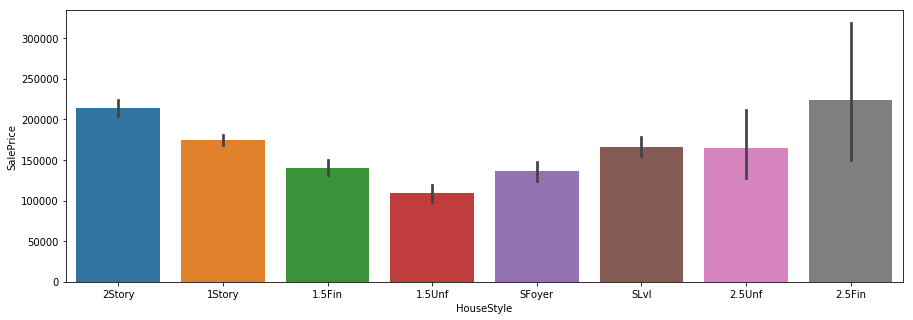

In [36]:
plt.figure(figsize=(15,5))
sns.barplot(x="HouseStyle", y="SalePrice", data=houseDataDF)

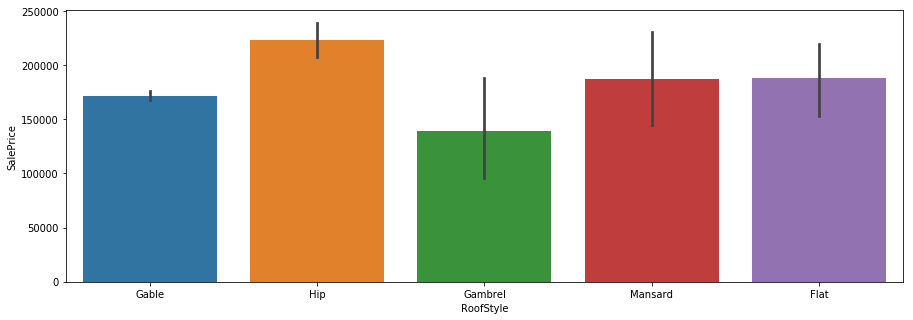

In [37]:
plt.figure(figsize=(15,5))
sns.barplot(x="RoofStyle", y="SalePrice", data=houseDataDF)

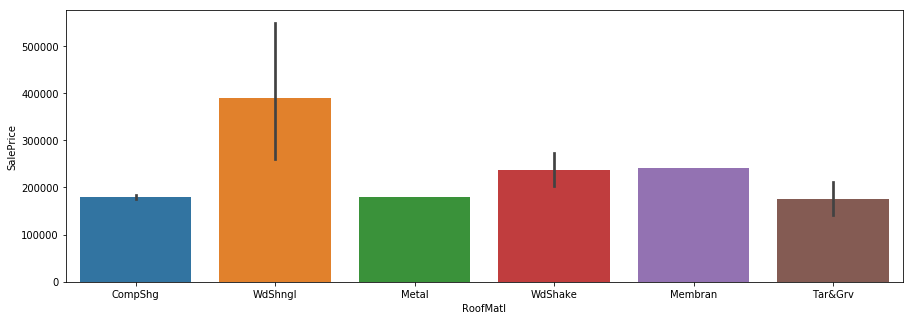

In [38]:
plt.figure(figsize=(15,5))
sns.barplot(x="RoofMatl", y="SalePrice", data=houseDataDF)

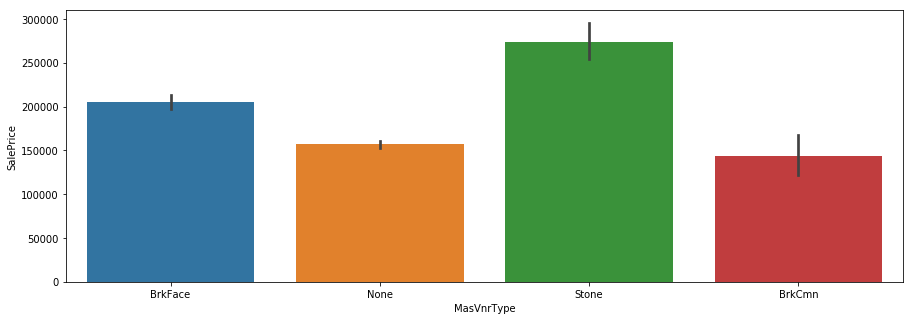

In [39]:
plt.figure(figsize=(15,5))
sns.barplot(x="MasVnrType", y="SalePrice", data=houseDataDF)

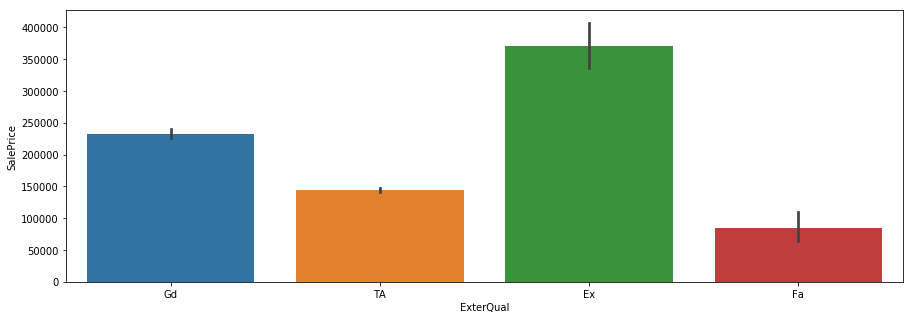

In [40]:
plt.figure(figsize=(15,5))
sns.barplot(x="ExterQual", y="SalePrice", data=houseDataDF)

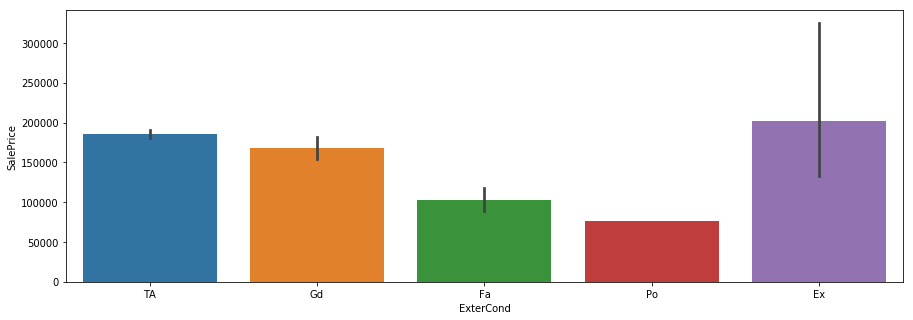

In [41]:
plt.figure(figsize=(15,5))
sns.barplot(x="ExterCond", y="SalePrice", data=houseDataDF)

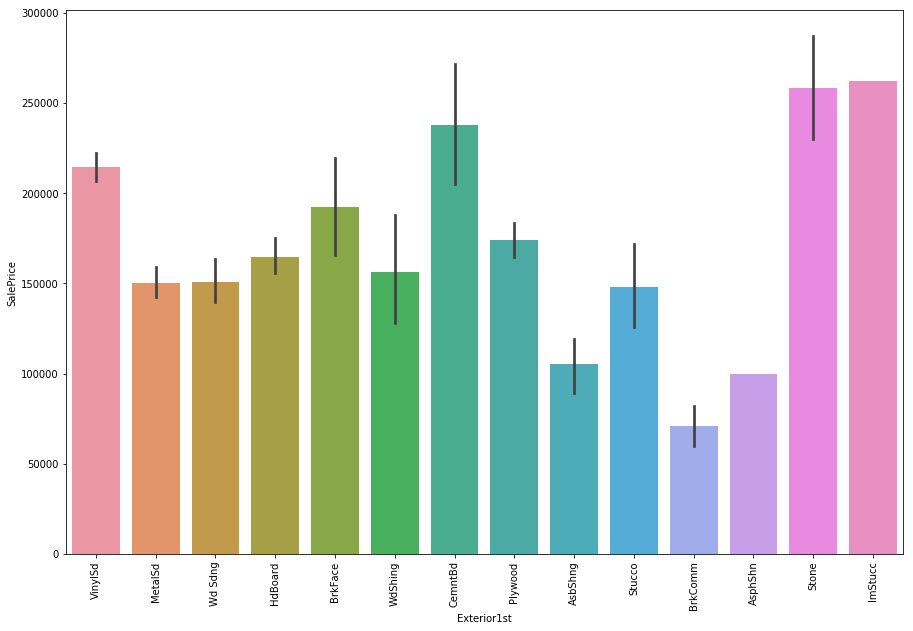

In [42]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior1st", y="SalePrice", data=houseDataDF)

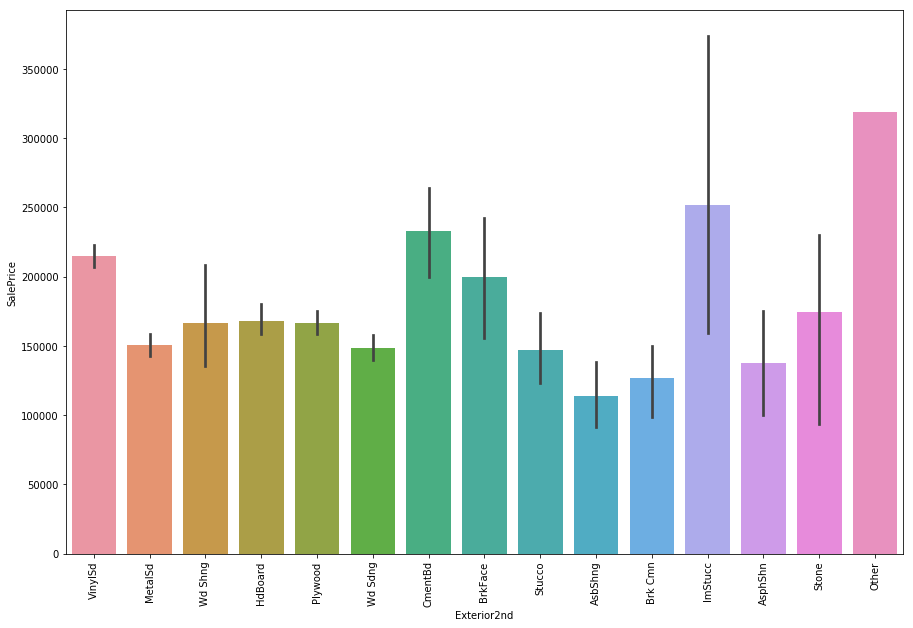

In [43]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Exterior2nd", y="SalePrice", data=houseDataDF)

# Cleaning the data

## Removing outliers

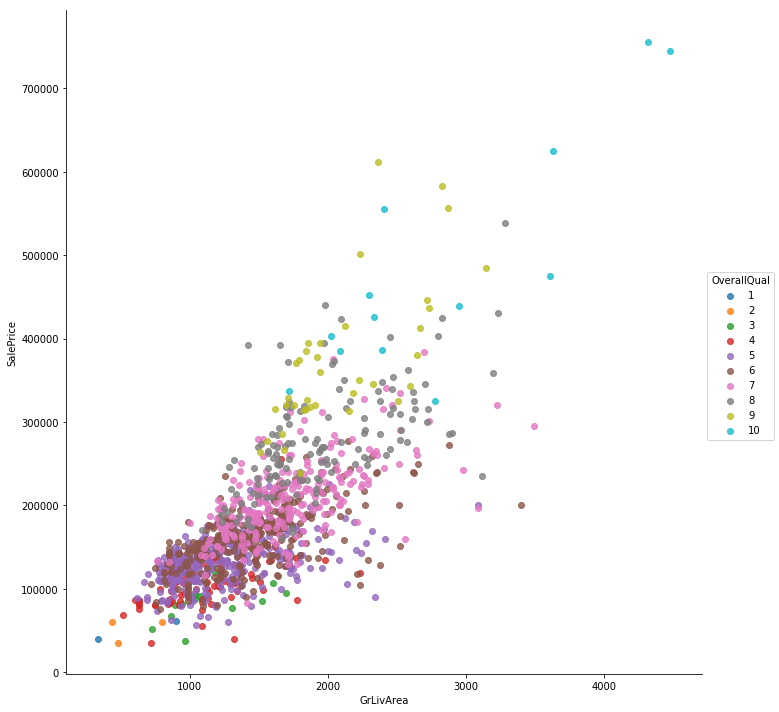

In [44]:
houseDataCleanedDF = houseDataDF.drop(outliers)
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataCleanedDF,fit_reg=False,size=10,hue="OverallQual")

## Feature engineering

In [45]:
y = np.log(houseDataCleanedDF.SalePrice)
houseDataCleanedDF = houseDataCleanedDF.drop(["SalePrice"],axis=1)
houseDataCleanedDF = pd.concat([houseDataCleanedDF,testDF])

In [46]:
def makeNewFeatures(houseDataDF):
    categorical_feats = houseDataDF.dtypes[houseDataDF.dtypes == "object"].index.values

    for feat in categorical_feats:
        if(feat == "Utilities"):
            continue
            
        dummies = pd.get_dummies(houseDataDF[feat], drop_first=True)
        num_categories = len(dummies.columns)
        houseDataDF[[feat+str(i) for i in range(num_categories)]] = dummies
    
    
    # CUSTOM FEATURES
    houseDataDF['NearPark'] = [1 if x=='PosN' or x=='PosA' or y=='PosN' or y=='PosA' else 0\
        for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]

    houseDataDF['Loudness'] = [1 if x=='Feedr' or x=='Artery' or x=='RRAe' or y=='Feedr'\
        or y=='Artery' or y=='RRAe' else 0 for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]
    
    houseDataDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    houseDataDF['TimeBetweenRemodAndBuild'] =  [x-y for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['RemodeledResent'] =  [1 if x != y and 2010 - x < 10 else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['Age'] =  [2010 - x for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['AvgQualCond'] =  [(int(x)+int(y))/2 for x,y in zip(houseDataDF["OverallQual"],houseDataDF["OverallCond"])]
    
    houseDataDF['TotalPorchSF'] = houseDataDF['OpenPorchSF'] + houseDataDF['EnclosedPorch'] + houseDataDF['3SsnPorch'] + houseDataDF['ScreenPorch']
    
    houseDataDF['OverallQualSquared'] = [x**2 for x in houseDataDF["OverallQual"]]
    
    houseDataDF['OverallCondSquared'] = [x**2 for x in houseDataDF["OverallCond"]]
    
    houseDataDF['avgQualCondSquared'] = [x**2 for x in houseDataDF["AvgQualCond"]]
    
    houseDataDF['SoldDuringFinancialCrysis'] = [1 if x == 2008 else 0 for x in houseDataDF["YrSold"]]
    
    houseDataDF['NoGarage'] = [1 if x == 0 else 0 for x in houseDataDF["GarageArea"]]
    # 
    return houseDataDF


houseDataCleanedDF = makeNewFeatures(houseDataCleanedDF)
# TODO : Add feature for centrality

## Fixing skew

In [47]:
def fixSkew(houseDataDF):
    numeric_feats = houseDataDF.dtypes[houseDataDF.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = houseDataDF[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


    skewed_features = skewness.index

    lam = 0.15
    
    for feat in skewed_features:
        #all_data[feat] += 1
        if(feat not in ["SalePrice","YearBuilt"]):
            houseDataDF[feat] = boxcox1p(houseDataDF[feat], lam)
    return houseDataDF

houseDataCleanedDF = fixSkew(houseDataCleanedDF)


Skew in numerical features: 

There are 257 skewed numerical features to Box Cox transform


# Predictions

https://datascienceplus.com/linear-regression-in-python-predict-the-bay-areas-home-prices/
https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
https://shankarmsy.github.io/stories/gbrt-sklearn.html
https://www.kaggle.com/nolberg/machine-learning-for-house-price-prediction
https://kaggle2.blob.core.windows.net/forum-message-attachments/216792/7200/MDSSKaggle_Slides_Henry.pdf
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example
https://www.kaggle.com/janiobachmann/in-depth-analysis-house-prices-ensembling
https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook
https://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

In [48]:
data = houseDataCleanedDF.select_dtypes(include=[np.number]).interpolate().dropna()
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

columns = data.columns.values

currentTrainSetLenght = trainSetLength - len(outliers)

trainData = pd.DataFrame(data=data.values[:currentTrainSetLenght],columns=columns)

testData = pd.DataFrame(data=data.values[currentTrainSetLenght:],columns=columns)



In [49]:
X = trainData
training_features = X.columns.values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

## Linear Regression

In [51]:
lr = LinearRegression()
linearModel = lr.fit(X_train,y_train)
print ("R^2 is:", linearModel.score(X_test, y_test))

R^2 is: 0.8577218079955353


In [52]:
predictions = linearModel.predict(X_test)

print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.021919775618215447


In [53]:
scores = cross_val_score(linearModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -1.72 (+/- 5.49)


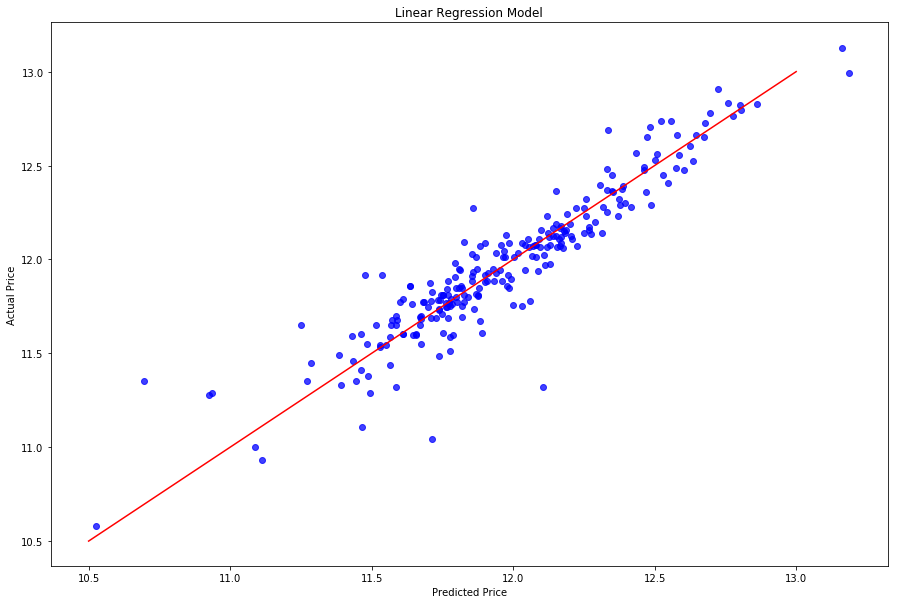

In [54]:

actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

### KernelRidge Regularization

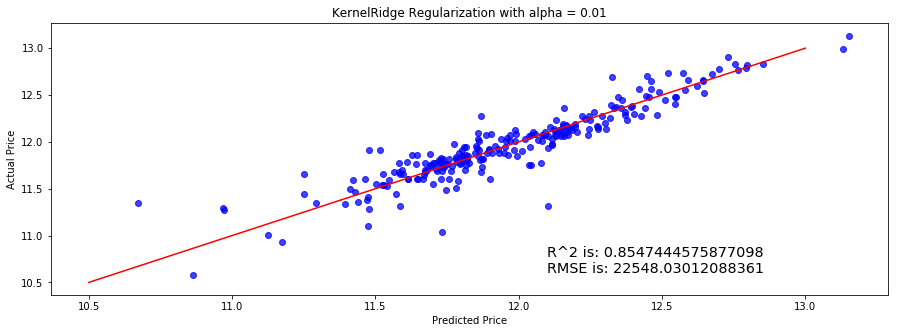

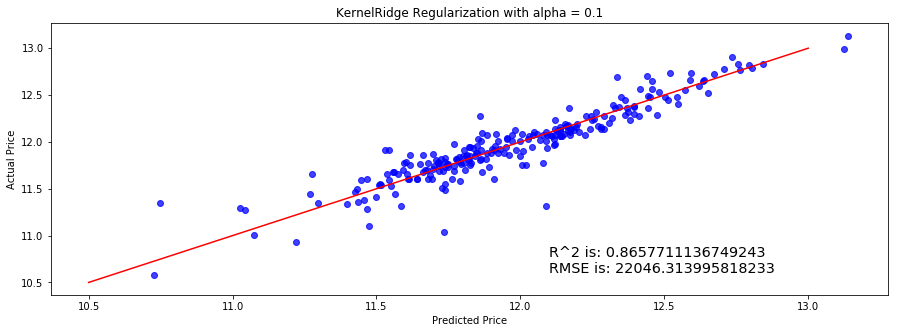

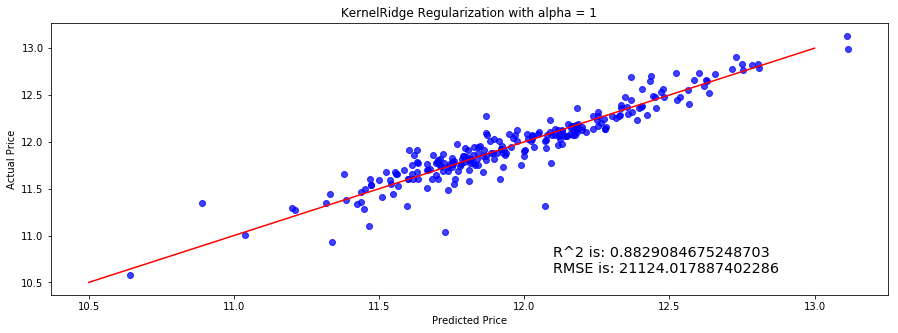

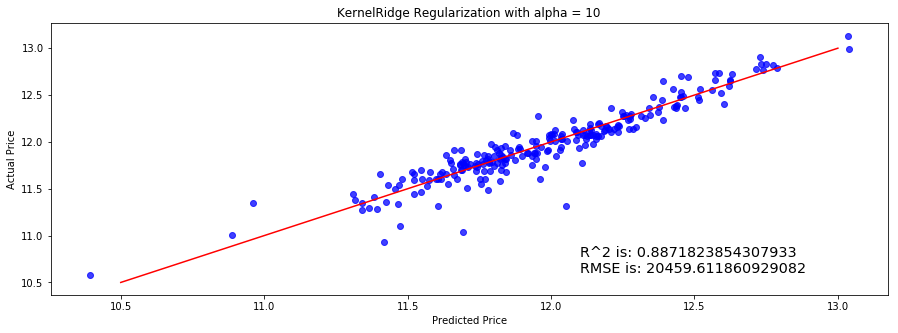

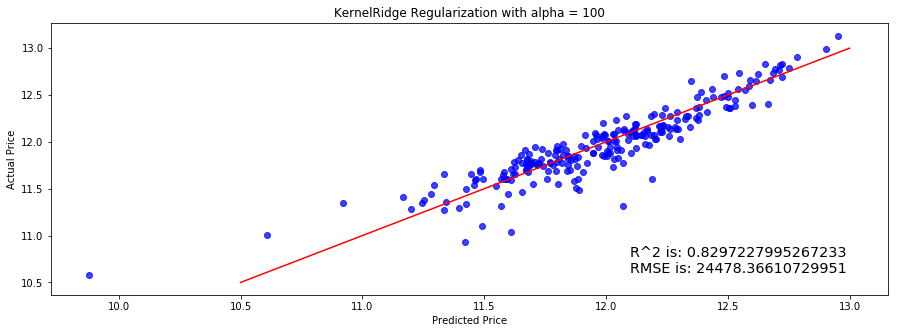

In [55]:
for alpha in [0.01,0.1,1,10,100]:
    rm = KernelRidge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('KernelRidge Regularization with alpha = {}'.format(alpha))
    rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds_ridge)))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    rmse)
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()


## BayesianRidge

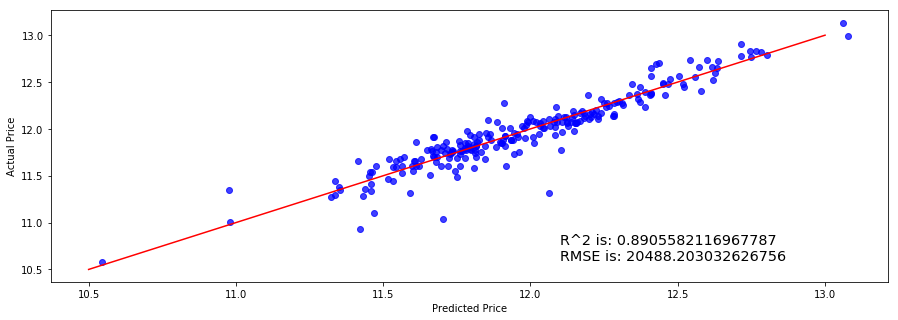

In [56]:

br = BayesianRidge(alpha_1=1e-08,alpha_2=5e-06)
bayesian_model = br.fit(X_train, y_train)
br_preds = bayesian_model.predict(X_test)
plt.figure(figsize=(15,5))
plt.scatter(br_preds, actual_values, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(br_preds)))

overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                bayesian_model.score(X_test, y_test),
                rmse)

plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


## Random Forrest

In [57]:
fr = RandomForestRegressor(n_estimators=100,random_state=42)
randomForrestModel = fr.fit(X_train, y_train)
print ("R^2 is:", randomForrestModel.score(X_test, y_test))

R^2 is: 0.865001173038501


In [58]:
fr_preds = randomForrestModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(fr_preds)))
print ('RMSE is:', rmse)

RMSE is: 23553.042766655883


In [59]:
scores = cross_val_score(randomForrestModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.19)


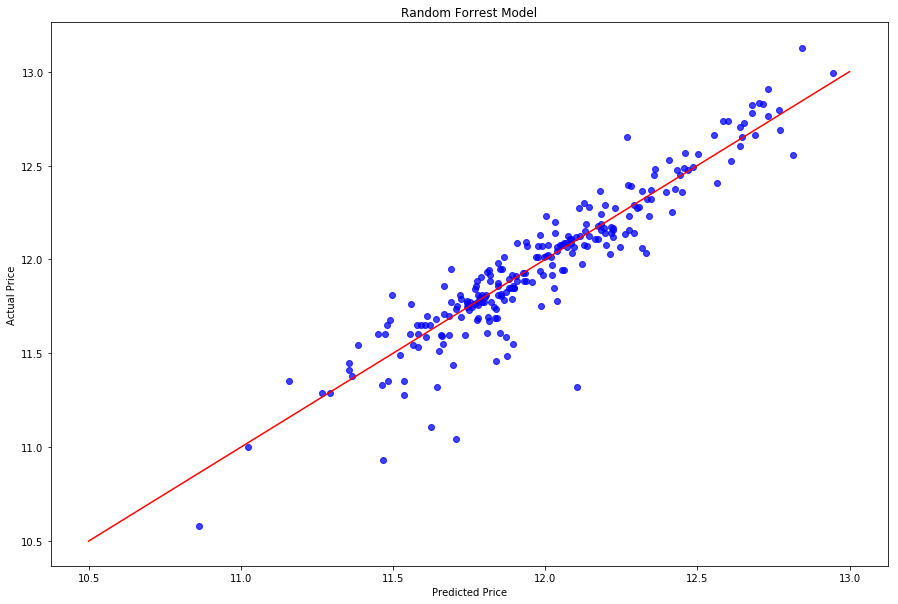

In [60]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(fr_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forrest Model')
plt.show()

## Support Vector Regressor

NameError: name 'rbf_model_model' is not defined

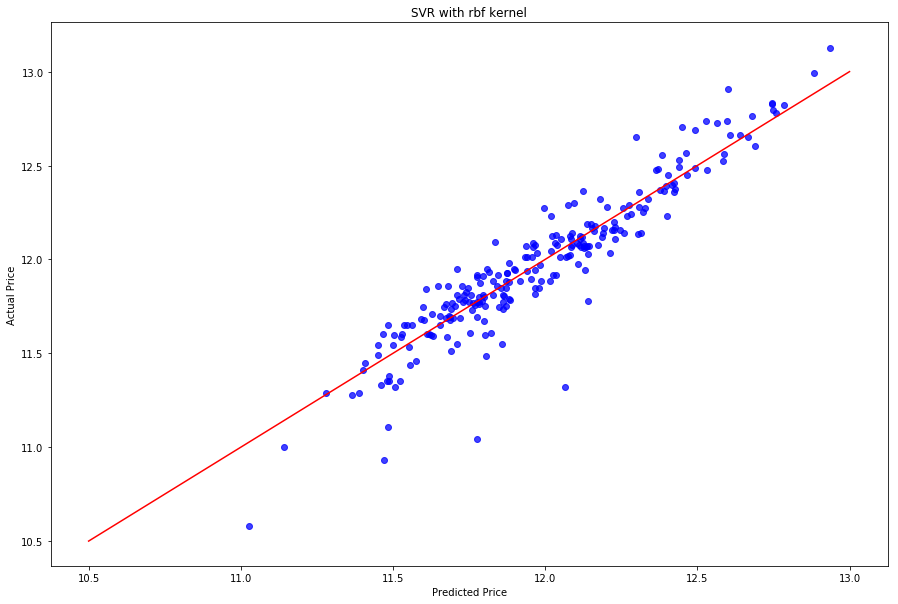

In [80]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
rbf_model = svr_rbf.fit(X_train, y_train)
lin_model = svr_lin.fit(X_train, y_train)
rbf_preds = rbf_model.predict(X_test)
lin_preds = lin_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(rbf_preds)))
lin_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lin_preds)))

plt.figure(figsize=(15,10))
plt.scatter(rbf_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SVR with rbf kernel')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                rbf_model.score(X_test, y_test),
                rbf_rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(lin_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SVR with linear kernel')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                lin_model.score(X_test, y_test),
                lin_rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


## Gradient boosting

In [62]:
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
n_jobs=4

In [63]:
def hyperparameterTuning(estimator,param_grid, n_jobs,cv): 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs,verbose=1)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_

In [64]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

R^2 is: 0.8778277925820294


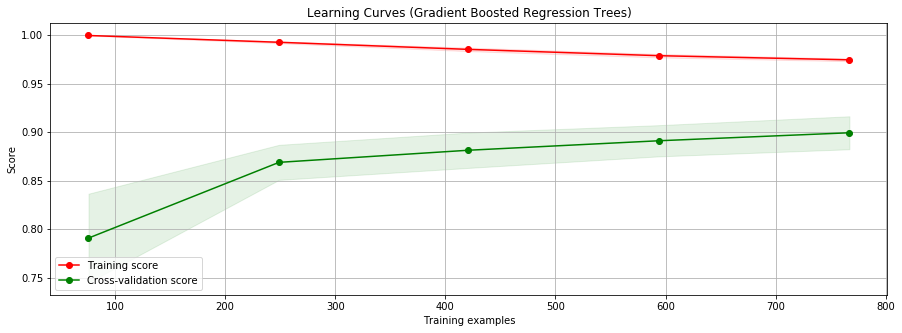

In [65]:
gb = GradientBoostingRegressor()
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(gb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
gradientBoostingModel = gb.fit(X_train, y_train)
print ("R^2 is:", gradientBoostingModel.score(X_test, y_test))

In [66]:
predictions = gradientBoostingModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions)))
print ('RMSE is:', rmse)

RMSE is: 20671.677250338336


In [67]:
scores = cross_val_score(gradientBoostingModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.16)


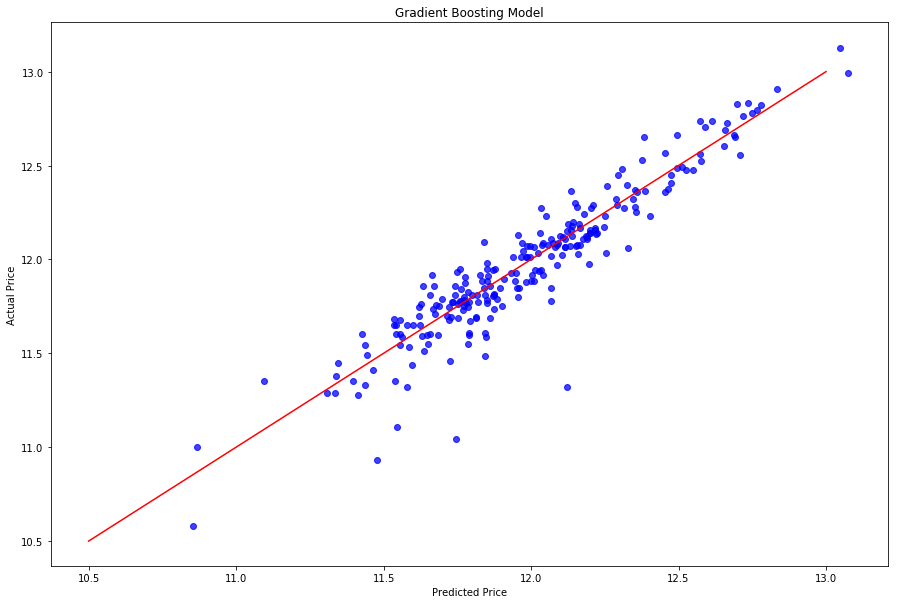

In [68]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

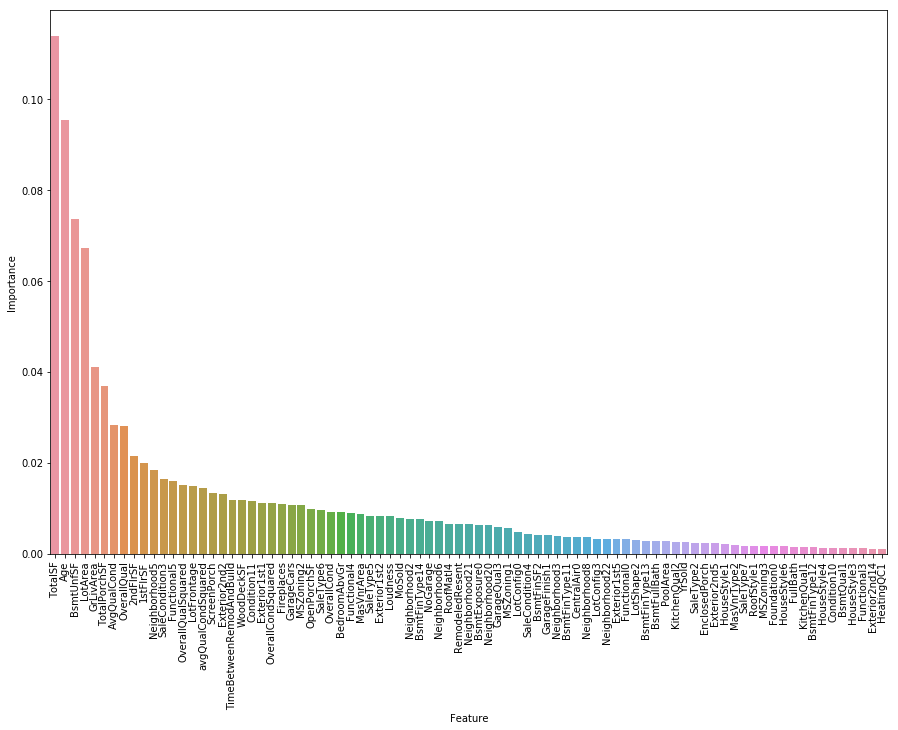

In [69]:
importances = gb.feature_importances_
columns = X_test.columns.values


feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))


featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0.001")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)


### Improving Gradient Boosting

In [70]:
param_grid={'n_estimators':[100],
            'learning_rate': [0.1],
            'max_depth':[6],
            'min_samples_leaf':[3],
            'max_features':[1.0],
           }

estimator = GradientBoostingRegressor()
cv,best_est = hyperparameterTuning(estimator,param_grid, n_jobs,cv)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.8s finished


Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

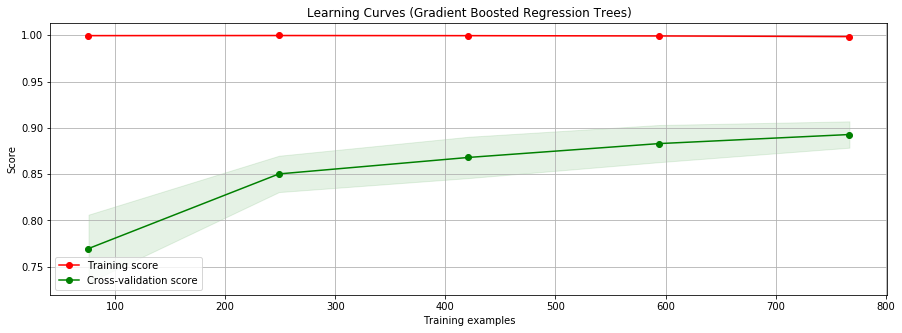

In [71]:
model_gb = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features)
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(model_gb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [72]:
model_gb.fit(X_train, y_train)
predictions = model_gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions)))
print ('RMSE is:', rmse)

RMSE is: 21432.866728831817


In [73]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4
#cv,best_est=GradientBooster(param_grid, n_jobs)

try:
    best_est = pickle.load( open( "GradientBoostingBestEstimator.p", "rb" ) )
    None
except:
    model_gb = GradientBoostingRegressor()
    cv,best_est = hyperparameterTuning(model_gb,param_grid, n_jobs,cv)
    None



In [74]:
pickle.dump(best_est, open( "GradientBoostingBestEstimator.p", "wb" ) )

KeyboardInterrupt: 

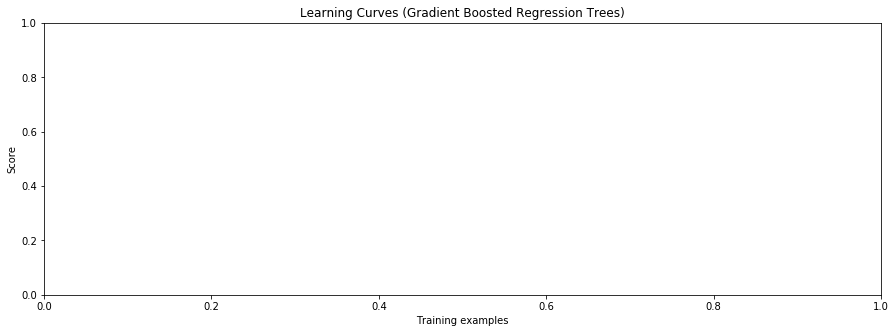

In [75]:
model_gb = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features,loss="huber",random_state=5)

title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(model_gb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)


In [ ]:
model_gb.fit(X_train, y_train)
gb_preds = model_gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gb_preds)))
print ("R^2 is:", model_gb.score(X_test, y_test))
print ('RMSE is:', rmse)

In [ ]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(gb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

### Using XGBoost 

In [ ]:
param_grid={'learning_rate': [0.05, 0.02, 0.01],
            'max_depth':[4,6,8],
            'gamma':[0.01,0.04,0.08,0.12], 
            'subsample':[0.5,0.75,1],
            'colsample_bytree':[0.5,0.75,1],
            'reg_alpha':[0.001,0.01,0.1],
            'reg_lambda':[0.001,0.01,0.1],
            'n_estimators':[2000,3000]
           }
model_xgb = xgb.XGBRegressor()
cv,best_est = hyperparameterTuning(model_xgb,param_grid, n_jobs,cv)
try:
    #best_est = pickle.load( open( "XGBoostBestEstimator.p", "rb" ) )
    None
except:
    #model_xgb = xgb.XGBRegressor()
    #cv,best_est = hyperparameterTuning(model_xgb,param_grid, n_jobs,cv)
    None

In [ ]:
pickle.dump(best_est, open( "XGBoostBestEstimator.p", "wb" ) )

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

title = "Learning Curves (XGBoost Regression Trees)"
#plot_learning_curve(model_xgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [ ]:
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(xgb_preds)))
print ("R^2 is:", model_xgb.score(X_test, y_test))
print ('RMSE is:', rmse)

In [ ]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(xgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Model')
plt.show()

### Using LightGBM

In [ ]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
"""
try:
    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )
except:
    model_lgb = lgb.LGBMRegressor()
    cv,best_est = hyperparameterTuning(model_lgb,param_grid, n_jobs,cv)
    None
"""

In [ ]:
#pickle.dump(best_est, open( "LightGBMBestEstimator.p", "wb" ) )

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
title = "Learning Curves (LightGBM Regression Trees)"
#plot_learning_curve(model_lgb, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [ ]:
model_lgb.fit(X_train, y_train)
lgb_preds = model_lgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lgb_preds)))
print ("R^2 is:", model_lgb.score(X_test, y_test))
print ('RMSE is:', rmse)

In [ ]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(lgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LightLGB Model')
plt.show()

# Using Lasso Regularization as a Meta-model

In [ ]:
rm = KernelRidge(alpha=10)
ridge_model = rm.fit(X_train, y_train)
rm_preds = ridge_model.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = model_gb.predict(X)
rm_test_preds = ridge_model.predict(X)
br_test_preds = bayesian_model.predict(X)
fr_test_preds = randomForrestModel.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T
all_test_preds = np.array([lgb_test_preds,xgb_test_preds,gb_test_preds,rm_test_preds]).T

lm = Lasso(alpha=0.001)
lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)
plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(meta_preds)))
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                ridge_model.score(X_test, y_test),
                rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

# Capturing large errors

In [ ]:

errorDF = pd.DataFrame(data=y_test)
errorDF["Prediction"] = lgb_preds

res = errorDF.query("SalePrice < 11 & Prediction < 11.5")

outliersDF = pd.DataFrame()
outliersDF["SalePrice"] = np.exp(res.SalePrice.values)
outliersDF["Prediction"] = np.exp(res.Prediction.values)
outliersDF.index = res.index
print(outliersDF)

In [ ]:
worstPredictions = houseDataDF.query("Id == 813 | Id == 534")
columns = np.concatenate((highestCorrFeatures,["Neighborhood"]))
worstPredictions[columns]

# Create submission

In [ ]:
lgb_preds = model_lgb.predict(testData)
xgb_preds = model_xgb.predict(testData)
gb_preds = model_gb.predict(testData)
rm_preds = ridge_model.predict(testData)
br_preds = bayesian_model.predict(testData)
fr_preds = randomForrestModel.predict(testData)

all_model_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission = pd.DataFrame()
submission['Id'] = idColl
submission['SalePrice'] = final_predictions
submission.head(20)

In [ ]:
testDataDF = pd.read_csv(base + "train2.csv")
ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = submission.SalePrice.values
ansDF.head(20)
#diff = np.sum(np.log(np.square((np.array(ansDF.values) - np.array(submission.SalePrice.values)))))


In [ ]:
print("Root mean squared error:")
print(np.sqrt(mean_squared_error(ansDF["SalePrice"],ansDF["Predicted"])))

In [ ]:
ansDF["Diff"] = abs(ansDF["SalePrice"] - ansDF["Predicted"])
ansDF = ansDF.sort_values(by="Diff",ascending=False)
ansDF.head(20)

In [ ]:
worstPredictions = testDataDF.query("Id == 1299 | Id == 1325 | Id == 1212 | Id == 1360 | Id == 1424 | Id == 1454")
columns = np.concatenate((highestCorrFeatures,["Neighborhood","YrSold"]))
worstPredictions[columns]

In [ ]:
submission.to_csv('submission1.csv', index=False)

In [ ]:
currentLabourForceDF = labourForceDF.query("Year <= 2011 & Year >= 2007")
currentLabourForceDF["MonthNum"] = [x*(y-2007) for x,y in zip(currentLabourForceDF.Month,currentLabourForceDF.Year)]

# Financial crysis model

In [ ]:
relevantTrainDataDF = houseDataDF.query("YrSold == 2008")

relevantTrainDataLenght = len(relevantTrainDataDF.values)

relevantTrainDataIds = relevantTrainDataDF.index.values

relevantTestDataDF = testDF.query("YrSold == 2008")

relevantTestDataIds = relevantTestDataDF.index.values

y = np.log(relevantTrainDataDF.SalePrice)

relevantTrainDataDF = relevantTrainDataDF.drop(["SalePrice"],axis=1)

totalRelevantDataDF = pd.concat([relevantTrainDataDF,relevantTestDataDF])

totalRelevantDataDF = makeNewFeatures(totalRelevantDataDF)

totalRelevantDataDF = fixSkew(totalRelevantDataDF)


In [ ]:
data = totalRelevantDataDF.select_dtypes(include=[np.number]).interpolate().dropna()
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

columns = data.columns.values


trainData = pd.DataFrame(data=data.values[:relevantTrainDataLenght],columns=columns)

testData = pd.DataFrame(data=data.values[relevantTrainDataLenght:],columns=columns)

X = trainData
training_features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

In [ ]:
rm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
bayesian_model.fit(X_train, y_train)
randomForrestModel.fit(X_train, y_train)

lgb_preds = model_lgb.predict(X_test)
xgb_preds = model_xgb.predict(X_test)
gb_preds = model_gb.predict(X_test)
rm_preds = ridge_model.predict(X_test)
br_preds = bayesian_model.predict(X_test)
fr_preds = randomForrestModel.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = model_gb.predict(X)
rm_test_preds = ridge_model.predict(X)
br_test_preds = bayesian_model.predict(X)
fr_test_preds = randomForrestModel.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T
all_test_preds = np.array([lgb_test_preds,xgb_test_preds,gb_test_preds,rm_test_preds]).T

lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)

plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(meta_preds)))
overlay = 'R^2 is: {}\nMSE is: {}'.format(
                ridge_model.score(X_test, y_test),
                rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


In [ ]:
importances = model_gb.feature_importances_
columns = X_test.columns.values


feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))


featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0.002")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

In [ ]:
lgb_preds = model_lgb.predict(testData)
xgb_preds = model_xgb.predict(testData)
gb_preds = model_gb.predict(testData)
rm_preds = ridge_model.predict(testData)
br_preds = bayesian_model.predict(testData)
fr_preds = randomForrestModel.predict(testData)

all_model_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission1 = pd.DataFrame()
submission1['Id'] = relevantTestDataIds
submission1['SalePrice'] = final_predictions
submission1.head(20)

## Non crysis model

In [ ]:
relevantTrainDataDF = houseDataDF.query("YrSold != 2008")

relevantTrainDataLenght = len(relevantTrainDataDF.values)

relevantTrainDataIds = relevantTrainDataDF.index.values

relevantTestDataDF = testDF.query("YrSold != 2008")

relevantTestDataIds = relevantTestDataDF.index.values

y = np.log(relevantTrainDataDF.SalePrice)

relevantTrainDataDF = relevantTrainDataDF.drop(["SalePrice"],axis=1)

totalRelevantDataDF = pd.concat([relevantTrainDataDF,relevantTestDataDF])

totalRelevantDataDF = makeNewFeatures(totalRelevantDataDF)

totalRelevantDataDF = fixSkew(totalRelevantDataDF)


In [ ]:
data = totalRelevantDataDF.select_dtypes(include=[np.number]).interpolate().dropna()
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

columns = data.columns.values


trainData = pd.DataFrame(data=data.values[:relevantTrainDataLenght],columns=columns)

testData = pd.DataFrame(data=data.values[relevantTrainDataLenght:],columns=columns)

X = trainData
training_features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

In [ ]:
rm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
bayesian_model.fit(X_train, y_train)
randomForrestModel.fit(X_train, y_train)

lgb_preds = model_lgb.predict(X_test)
xgb_preds = model_xgb.predict(X_test)
gb_preds = model_gb.predict(X_test)
rm_preds = ridge_model.predict(X_test)
br_preds = bayesian_model.predict(X_test)
fr_preds = randomForrestModel.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = model_gb.predict(X)
rm_test_preds = ridge_model.predict(X)
br_test_preds = bayesian_model.predict(X)
fr_test_preds = randomForrestModel.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T
all_test_preds = np.array([lgb_test_preds,xgb_test_preds,gb_test_preds,rm_test_preds]).T

lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)

plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(meta_preds)))
overlay = 'R^2 is: {}\nMSE is: {}'.format(
                ridge_model.score(X_test, y_test),
                rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

In [ ]:
importances = model_gb.feature_importances_
columns = X_test.columns.values


feature_importance = list(zip(columns,importances))
sorted_feature_importance = np.array(sorted(feature_importance,key=lambda x : x[1],reverse=True))
sorted_feature_importance = list(map(lambda x : [x[0],float(x[1])],sorted_feature_importance))


featureImportanceDF = pd.DataFrame(data=sorted_feature_importance,columns=["Feature","Importance"]).query("Importance > 0.002")
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

In [ ]:
lgb_preds = model_lgb.predict(testData)
xgb_preds = model_xgb.predict(testData)
gb_preds = model_gb.predict(testData)
rm_preds = ridge_model.predict(testData)
br_preds = bayesian_model.predict(testData)
fr_preds = randomForrestModel.predict(testData)

all_model_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds]).T

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission2 = pd.DataFrame()
submission2['Id'] = relevantTestDataIds
submission2['SalePrice'] = final_predictions
submission2.head(20)

In [ ]:
allSubmission = pd.concat([submission1,submission2]).sort_values("Id")
allSubmission.head(20)

In [ ]:
allSubmission.to_csv('submission3.csv', index=False)

In [ ]:
testDataDF = pd.read_csv(base + "train2.csv")
ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = allSubmission.SalePrice.values
ansDF.head(20)

In [ ]:
ansDF["Diff"] = abs(ansDF["SalePrice"] - ansDF["Predicted"])
ansDF = ansDF.sort_values(by="Diff",ascending=False)
ansDF.head(20)

In [ ]:
print("Root mean squared error:")
print(np.sqrt(mean_squared_error(ansDF["SalePrice"],ansDF["Predicted"])))

In [ ]:
worstPredictions = testDataDF.query("Id == 1299 | Id == 1325 | Id == 1244 | Id == 1374 | Id == 1311")
columns = np.concatenate((highestCorrFeatures,["Neighborhood","YrSold","MoSold"]))
worstPredictions[columns]